In [2]:
%pip install pybaseball

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Gathering player lookup table. This may take a moment.
  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0     judge      aaron     592450  judga001  judgeaa01          15640   

   mlb_played_first  mlb_played_last  
0            2016.0           2025.0  
Gathering Player Data


c:\Users\jeanpc\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


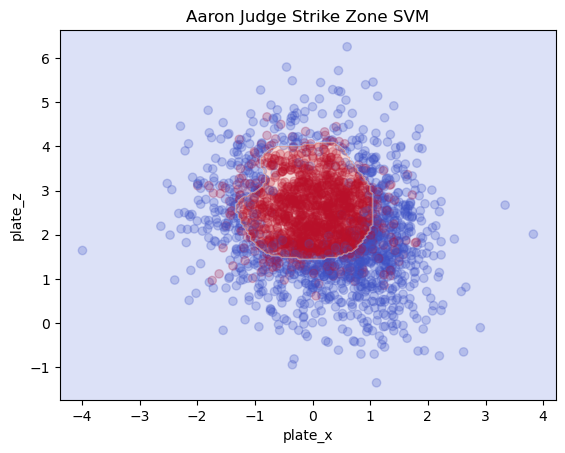

Validation Accuracy: 0.8631239935587761


In [3]:
# Step 1: Install pybaseball if needed
# pip install pybaseball

from pybaseball import statcast_pitcher
from pybaseball.playerid_lookup import playerid_lookup
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np

# Step 2: Get Aaron Judge's MLBAM ID
player_info = playerid_lookup('judge', 'aaron')
print(player_info)

# Step 3: Get pitch data for Aaron Judge — he's a hitter, so we need pitches thrown *to* him
# Use statcast_batter instead (pitcher version only gets pitchers)
from pybaseball import statcast_batter

aaron_judge_id = int(player_info['key_mlbam'].values[0])

# Get data over a time range (example: full 2022 season)
data = statcast_batter('2022-04-01', '2022-10-01', aaron_judge_id)

# Step 4: Clean and prepare dataset
aaron_judge = data[['plate_x', 'plate_z', 'type', 'description']]

# Filter only strikes (S) and balls (B)
aaron_judge = aaron_judge[aaron_judge['type'].isin(['S', 'B'])]

# Encode strike as 1, ball as 0
aaron_judge['type'] = aaron_judge['type'].map({'S': 1, 'B': 0})

# Drop missing values
aaron_judge = aaron_judge.dropna(subset=['plate_x', 'plate_z', 'type'])

# Step 5: Visualization and SVM classification
fig, ax = plt.subplots()

# Scatter plot of pitches
plt.scatter(x=aaron_judge['plate_x'], y=aaron_judge['plate_z'], 
            c=aaron_judge['type'], cmap=plt.cm.coolwarm, alpha=0.25)

# Split into training/validation sets
training_set, validation_set = train_test_split(aaron_judge, random_state=1)

# Train the SVM
classifier = SVC(kernel='rbf', gamma=3, C=1)
classifier.fit(training_set[['plate_x', 'plate_z']], training_set['type'])

# Draw decision boundary
def draw_boundary(ax, clf):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 200),
                         np.linspace(ylim[0], ylim[1], 200))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

draw_boundary(ax, classifier)

# Labels
plt.xlabel('plate_x')
plt.ylabel('plate_z')
plt.title('Aaron Judge Strike Zone SVM')

plt.show()

# Accuracy of model
print("Validation Accuracy:", classifier.score(validation_set[['plate_x', 'plate_z']], validation_set['type']))
